In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("data_tutorial.csv")
train, test = train_test_split(data, test_size = 0.3, random_state = 123)
validation, test = train_test_split(test, test_size = 0.33, random_state = 123) 

In [2]:
train["wordcount"] = train["body"].apply(lambda n: len(n.split()))
train.wordcount.sum()
train.groupby("category").describe()

Unnamed: 0                                                   \
                   count         mean          std   min      25%     50%   
category                                                                    
ADHS              5060.0  3890.024111  2275.930838  20.0  1958.75  3860.0   
depression_de     5042.0  4094.199127  2352.154173   1.0  2079.50  4088.5   

                                wordcount                                    \
                   75%      max     count       mean         std  min   25%   
category                                                                      
ADHS           5804.25  13982.0    5060.0  68.984190   92.782865  1.0  17.0   
depression_de  6114.50   8215.0    5042.0  81.485323  107.970570  1.0  15.0   

                                    
                50%    75%     max  
category                            
ADHS           40.0   85.0  1346.0  
depression_de  46.0  106.0  1179.0

Text(0.5, 1.0, '30 Most Common Words in our Corpora')

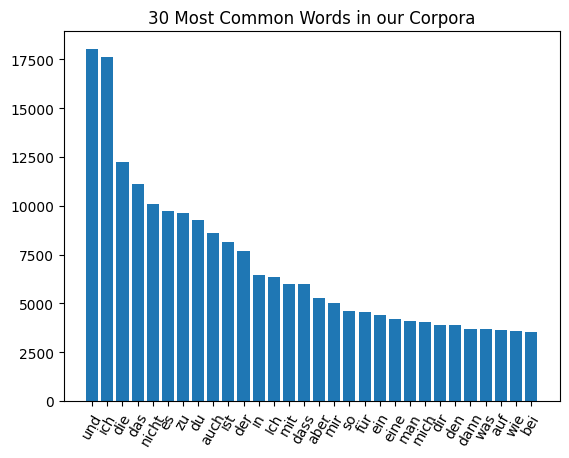

In [3]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

fdist = FreqDist()

for comment in train.body:
    for word in comment.split():
        fdist[word] += 1
        
most_common_plot = pd.Series(dict(fdist.most_common(30)))
plt.bar(x=most_common_plot.index, height=most_common_plot.values)
plt.xticks(rotation=60)
plt.title("30 Most Common Words in our Corpora")


In [4]:
import re

pattern = r'[^\w\s]' #Regular Expression select everything besides characters and whitespaces.
train['body_cleaned'] = train['body'].apply(lambda x: re.sub(pattern, '', x))
train['body_cleaned']= train['body_cleaned'].str.replace("\n"," ").str.lower()

In [5]:
from nltk.stem.snowball import GermanStemmer

st = GermanStemmer()
train["stemmed"] = train['body_cleaned'].apply(lambda x: [st.stem(y) for y in x.split()])

In [6]:
from nltk.corpus import stopwords

german_stop_words = stopwords.words('german')
train['body_stem_nostop'] = train["stemmed"].apply(lambda x: [item for item in x if item not in german_stop_words])

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(analyzer=lambda x: x).fit(train['body_stem_nostop'])
tf = TfidfVectorizer(analyzer=lambda x: x).fit(train['body_stem_nostop'])

cv_data = cv.transform(train['body_stem_nostop'])
tf_data = tf.transform(train['body_stem_nostop'])

In [8]:
from sklearn.linear_model import LogisticRegression

cvlog = LogisticRegression().fit(cv_data, train["category"])
tflog = LogisticRegression().fit(tf_data, train["category"])

test_data_cv = cv.transform([["beispiel", "wort", "fur", "vorhersag"]])
test_data_tf = tf.transform([["aktiv", "konzentration"]])

cvlog.predict(test_data_cv)
tflog.predict(test_data_tf)

C:\Users\49157\anaconda3\envs\cuda-torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['ADHS'], dtype=object)

In [9]:
import gensim.models.keyedvectors as word2vec
import gensim
import urllib.request 

urllib.request.urlretrieve('https://cloud.devmount.de/d2bc5672c523b086/german.model', 'word2vecgerman.model')
model = gensim.models.KeyedVectors.load_word2vec_format('./word2vecgerman.model', binary=True)

In [10]:
import numpy as np

words = set(model.index_to_key )
train["embedd"] = np.array([np.array([model[i] for i in ls.split(" ") if i in words]) for ls in train["body"]])

C:\Users\49157\AppData\Local\Temp\ipykernel_21168\129068271.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train["embedd"] = np.array([np.array([model[i] for i in ls.split(" ") if i in words]) for ls in train["body"]])


In [11]:
train_vect_avg = []
for values in train["embedd"]:
    if  values.size:
        train_vect_avg.append(np.mean(values, axis=0))
    else:
        train_vect_avg.append(np.zeros(300, dtype=float))

w2vmodel = LogisticRegression().fit(pd.DataFrame(train_vect_avg), train["category"])

In [15]:
import fasttext.util

fasttext.util.download_model('de', if_exists='ignore') 
ft = fasttext.load_model('cc.de.300.bin')

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
train["embedd_fasttext"] = train['body_cleaned'].apply(lambda x: ft.get_sentence_vector(x))
fasttext_train = train["embedd_fasttext"].apply(lambda x: pd.Series(x)) #Flatten Arrays into single columns
fastmodel = LogisticRegression().fit(fasttext_train, train["category"])

In [17]:
from gensim.models import Word2Vec

w2v_model = gensim.models.Word2Vec(train["body_stem_nostop"],
                                   vector_size=500,
                                   window=5,
                                   min_count=10)

words = set(w2v_model.wv.index_to_key )

train["embedd_own"] = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in train["body_stem_nostop"]])


train_vect_avg = []
for value in train["embedd_own"]:
    if value.size:
        train_vect_avg.append(value.mean(axis=0))
    else:
        train_vect_avg.append(np.zeros(500, dtype=float))

selftrainedw2v = LogisticRegression().fit(pd.DataFrame(train_vect_avg), train["category"])

C:\Users\49157\AppData\Local\Temp\ipykernel_21168\2325199192.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train["embedd_own"] = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\49157\anaconda3\envs\cuda-torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
train['category_fasttext'] = '__label__' + train['category']
fasttexttrain = train['category_fasttext'] + " " + train['body_stem_nostop'].apply(lambda word_list: ' '.join(word_list))

f_train = open("train.txt", "a", encoding="utf-8")
for i in range(len(np.array(fasttexttrain))):
    f_train.write(np.array(fasttexttrain)[i] + "\n")
f_train.close()

model = fasttext.train_supervised(input="train.txt")

In [2]:
import torch 
torch.cuda.is_available()


True

In [3]:
from datasets import Dataset
from transformers import AutoTokenizer

train["text"] = train["body"]
train["label"] = train["category"].replace(['ADHS','depression_de'],[0,1])

train_transformer = train[["label", "text"]]
data = Dataset.from_pandas(train_transformer)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-german-cased")

def tokenize(dataset):
    return tokenizer(dataset["text"], truncation=True, padding="max_length", max_length =512)

data_tokenized = data.map(tokenize)


C:\Users\49157\anaconda3\envs\cuda-torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-german-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    report_to= "none",
    num_train_epochs=5,
)

# Train the model
trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset=data_tokenized,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.494400
1000,0.416000
1500,0.339300
2000,0.282500
2500,0.276800
3000,0.156500
3500,0.156600
4000,0.107800
4500,0.071300
5000,0.088900


TrainOutput(global_step=6315, training_loss=0.19868667403196213, metrics={'train_runtime': 5928.9907, 'train_samples_per_second': 8.519, 'train_steps_per_second': 1.065, 'total_flos': 6690928306114560.0, 'train_loss': 0.19868667403196213, 'epoch': 5.0})

In [22]:
trainer.predict(data_tokenized.select(range(10)))
trainer.save_model("distillbert_german_classification_reddit")

In [28]:
from skllm import ZeroShotGPTClassifier
from skllm.config import SKLLMConfig

SKLLMConfig.set_openai_key("not used as locally, but needed anyway.") 
SKLLMConfig.set_openai_org("any string can be used")

clf = ZeroShotGPTClassifier(openai_model="gpt4all::mistral-7b-instruct-v0.1.Q4_0.gguf")

clf.fit(None, ["aufmerksamkeitsdefizit subreddit", "depression subreddit"])
clf.predict(["Example Comment"])

ImportError: cannot import name 'deprecated' from 'typing_extensions' (C:\Users\49157\anaconda3\envs\cuda-torch\lib\site-packages\typing_extensions.py)